<a href="https://colab.research.google.com/github/mithinKumar/Virtual-Try-on-Closet-using-GAN-SOC/blob/main/Trained_UNet_PascalVOC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import DataLoader,ConcatDataset
import matplotlib.pyplot as plt
import cv2

In [61]:
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])


In [62]:
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=image_transform, target_transform=mask_transform)
val_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=image_transform, target_transform=mask_transform)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [63]:
# Create DataLoader
# Combine training and validation datasets
combined_dataset = ConcatDataset([train_dataset, val_dataset])
train_loader = DataLoader(combined_dataset, batch_size=4, shuffle=True)


In [64]:
def visualize_batch(images, masks):
    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
    for i in range(4):
        axs[i, 0].imshow(images[i].permute(1, 2, 0))  # Convert CHW to HWC for matplotlib
        axs[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Display mask in grayscale
    plt.show()

In [65]:
!pip install segmentation_models_pytorch

In [66]:
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.optim as optim

# Load the pretrained U-Net model with ResNet-34 encoder
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=20  # Number of classes for Pascal voc
)

In [67]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(device)

cuda


In [68]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [69]:
from tqdm import tqdm
progress_bar = tqdm(total=len(train_dataset), desc='Training', leave = True)

Training:   0%|          | 0/1464 [00:00<?, ?it/s]

In [70]:
# Training loop
num_epochs = 10

model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:

        torch.set_printoptions(threshold=10000, edgeitems=1000, linewidth=1000)

        inputs, labels = inputs.to(device), labels.to(device).long()


        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.update(1)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')
progress_bar.close()

Training:  50%|████▉     | 731/1464 [01:12<01:02, 11.65it/s]

Epoch 1/10, Loss: 0.28287134385975626


Training: 100%|█████████▉| 1459/1464 [02:19<00:00, 12.30it/s]

Epoch 2/10, Loss: 0.18823922386671454


Training: 2189it [03:25, 10.58it/s]

Epoch 3/10, Loss: 0.18270990132917592


Training: 2918it [04:32, 12.12it/s]

Epoch 4/10, Loss: 0.18207787336022765


Training: 3647it [05:38, 11.91it/s]

Epoch 5/10, Loss: 0.18052376211915977


Training: 4376it [06:45, 11.73it/s]

Epoch 6/10, Loss: 0.1800352780886802


Training: 5104it [07:51, 12.35it/s]

Epoch 7/10, Loss: 0.1785442819065109


Training: 5833it [08:57, 12.37it/s]

Epoch 8/10, Loss: 0.17760818377034981


Training: 6562it [10:03, 12.27it/s]

Epoch 9/10, Loss: 0.17689883232689035


Training: 7290it [11:09, 10.89it/s]

Epoch 10/10, Loss: 0.1780652995176603


In [80]:
def decode_segmap(image, colormap):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, len(colormap)):
        idx = image == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

In [81]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# After uploading, specify the filename and load the image
file_name = "2008_000005.jpg"
test_img_path = file_name

test_img = Image.open(test_img_path).convert("RGB")
test_img = transform(test_img).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(test_img)
output = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()



Saving 2008_000005.jpg to 2008_000005 (3).jpg


In [82]:
def create_pascal_voc_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [0, 0, 0]          # background
    colormap[1] = [128, 0, 0]        # aeroplane
    colormap[2] = [0, 128, 0]        # bicycle
    colormap[3] = [128, 128, 0]      # bird
    colormap[4] = [0, 0, 128]        # boat
    colormap[5] = [128, 0, 128]      # bottle
    colormap[6] = [0, 128, 128]      # bus
    colormap[7] = [128, 128, 128]    # car
    colormap[8] = [64, 0, 0]         # cat
    colormap[9] = [192, 0, 0]        # chair
    colormap[10] = [64, 128, 0]      # cow
    colormap[11] = [192, 128, 0]     # dining table
    colormap[12] = [64, 0, 128]      # dog
    colormap[13] = [192, 0, 128]     # horse
    colormap[14] = [64, 128, 128]    # motorbike
    colormap[15] = [192, 128, 128]   # person
    colormap[16] = [0, 64, 0]        # potted plant
    colormap[17] = [128, 64, 0]      # sheep
    colormap[18] = [0, 192, 0]       # sofa
    colormap[19] = [128, 192, 0]     # train
    colormap[20] = [0, 64, 128]      # tv/monitor
    return colormap


In [83]:
colormap = create_pascal_voc_label_colormap()
segmentation_map = decode_segmap(output, colormap)

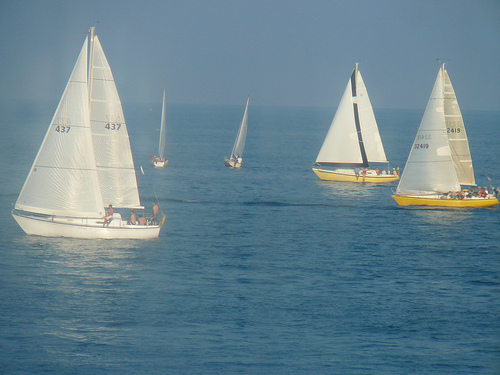

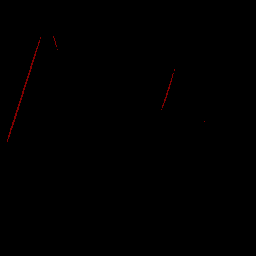

In [84]:
import cv2
from google.colab.patches import cv2_imshow

# Load and display the original image
img = cv2.imread(test_img_path)
cv2_imshow(img)

# Display the segmentation map (assuming 'segmentation_map' is properly defined)
cv2_imshow(cv2.cvtColor(segmentation_map, cv2.COLOR_RGB2BGR))
cv2.waitKey(0)
cv2.destroyAllWindows()


In [76]:
print(len(combined_dataset))

2913


In [77]:
# Save the model weights
model_save_path = 'unet_cityscapes.pth'
torch.save(model.state_dict(), model_save_path)


In [78]:
# Load the model weights
model_load_path = 'unet_cityscapes.pth'
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.eval()  # Set the model to evaluation mode

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track